                                                CS210 - Introduction to Data Science
                                                              Term Project

                                                        Berke Ayyıldızlı - 31018

My project is about how my driving affects my heart beats per minute. For this, i needed to explain both my health data, which i took from Apple Health, and my driving data, which i took from Opel's myOpel app. Further information about the datasets and the findings will be explained on the PDF file. Explainers and the comments are just for understanding the code and the steps that i took to clean, explore and visualize my data.

Disclaimer

myopel_trips.csv, which holds my trip data, is taken from Opel's myOpell app, i am using it directly.
Other csv files: calorie_burn_data.csv, heart_rate_data.csv, step_count_data.csv, weight_data.csv are parsed from my Apple Health's export.csv.

I have all the neccessary codes and data for parsing the export.csv, but for 2 reasons i am not sharing this data, as it is also said to us to not share data, i am still posting the previously mentioned ones.

The reasons are:
    1. The export.csv is more than 550 mb's.
    2. It holds crucially personal information from 2018 to today, including all my device's information, my activities, measurements and gps information.

Let's start with the project.

Neccesary Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import calendar
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

Cleaning The Data

In [2]:
# Reading the trip data to a dataframe
myopel_trips_df = pd.read_csv('myopel_trips.csv', delimiter=';')

# Filling the nan values
columns_to_fill = ['Average consumption (l/100km)', 'Average Speed (km/h)']
myopel_trips_df[columns_to_fill] = myopel_trips_df[columns_to_fill].fillna(myopel_trips_df[columns_to_fill].mean())

In [3]:
# Reading other csv files into separate dataframes
calorie_burn_df = pd.read_csv('calorie_burn_data.csv')
step_count_df = pd.read_csv('step_count_data.csv')

# Converting 'Date' columns to datetime format, as it can't be interpreted at this stage
calorie_burn_df['Date'] = pd.to_datetime(calorie_burn_df['Date'])
step_count_df['Date'] = pd.to_datetime(step_count_df['Date'])

# Grouping by 'Date' and sum the 'CaloriesBurned' and 'StepCount' for each day
calories_per_day = calorie_burn_df.groupby('Date')['CaloriesBurned'].sum().reset_index()
steps_per_day = step_count_df.groupby('Date')['StepCount'].sum().reset_index()

# Merging the said dataframes on 'Date'
combined_df_move = pd.merge(calories_per_day, steps_per_day, on='Date', how='outer')
combined_df_move['CaloriesBurned'] = combined_df_move['CaloriesBurned'].fillna(combined_df_move['CaloriesBurned'].mean())
combined_df_move['StepCount'] = combined_df_move['StepCount'].fillna(combined_df_move['StepCount'].mean())

In [4]:
# Reading the heart rate data abd forming a new dataframe for it
heart_rate_df = pd.read_csv('heart_rate_data.csv')

# Converting 'Date' columns to datetime format, as it can't be interpreted at this stage
heart_rate_df['Date'] = pd.to_datetime(heart_rate_df['Date'])
myopel_trips_df['Date'] = pd.to_datetime(myopel_trips_df['Date'], format='%d.%m.%Y')

# Droping the 'Time' column from heart_rate_df
heart_rate_df.drop(columns=['Time'], inplace=True)

# Calculating average BPM for each day from heart_rate_df
average_bpm_per_day = heart_rate_df.groupby('Date')['BPM'].mean()

# Merged myopel_trips_df with average_bpm_per_day, to evaluate later
myopel_trips_df = pd.merge(myopel_trips_df, average_bpm_per_day, how='left', on='Date')

# Renamed the merged column to 'BPM'
myopel_trips_df.rename(columns={'BPM': 'averageBPM'}, inplace=True)

# Calculating the overall average BPM from 'averageBPM' column in myopel_trips_df
overall_average_bpm = myopel_trips_df['averageBPM'].mean()

# Filling the nan values
myopel_trips_df['averageBPM'].fillna(overall_average_bpm, inplace=True)

In [5]:
# Reading the weight data
weight_data_df = pd.read_csv('weight_data.csv', delimiter=';')

Exploring the Dataset

The Health Dataframe

In [6]:
pd.set_option('display.max_columns', None)  #the combined health dataframe
display(combined_df_move.head(3))

,Date,CaloriesBurned,StepCount
0,2018-12-01,587.047,28871.0
1,2018-12-02,211.183,15210.0
2,2018-12-08,318.357,7906.0


The trip Dataframe

In [7]:
pd.set_option('display.max_columns', None)  #the trip dataframe
display(myopel_trips_df.head(3))

,Date,Departure Time,Arrival Time,Time Amount,Distance (km),Odometer Kilometer (km),Average consumption (l/100km),Fuel Prices (TRY/l),Cost (TRY),Average Speed (km/h),averageBPM
0,2023-06-11,15:26,15:30,0:04,1.0,13233,6.2,24.34,1.50,15,93.102113
1,2023-06-11,15:31,15:52,0:21,18.7,13252,3.3,24.34,14.96,54,93.102113
2,2023-06-11,16:31,17:09,0:37,39.6,13292,4.1,24.34,39.39,64,93.102113


Some Basic Statistics

In [8]:
# Displaying information about the dataframes
myopel_trips_df.info()

combined_df_move.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           364 non-null    datetime64[ns]
 1   Departure Time                 364 non-null    object        
 2   Arrival Time                   364 non-null    object        
 3   Time Amount                    364 non-null    object        
 4   Distance (km)                  364 non-null    float64       
 5   Odometer Kilometer (km)        364 non-null    int64         
 6   Average consumption (l/100km)  364 non-null    float64       
 7   Fuel Prices (TRY/l)            363 non-null    float64       
 8   Cost (TRY)                     363 non-null    float64       
 9   Average Speed (km/h)           364 non-null    int64         
 10  averageBPM                     364 non-null    float64       
dtypes: datetime64[ns](1

Some Basic Statistics

In [9]:
# Basic Statistics for the dataframes
print("Summary Statistics for myopel_trips_df:")
print(myopel_trips_df.describe())

print("\nSummary Statistics for combined_df_move:")
print(combined_df_move.describe())

print("\nSummary Statistics for heart_rate_df:")
print(heart_rate_df.describe())

Summary Statistics for myopel_trips_df:
                                Date  Distance (km)  Odometer Kilometer (km)  \
count                            364     364.000000               364.000000   
mean   2023-09-01 03:05:56.043955968       9.364011             16305.013736   
min              2023-06-11 00:00:00       0.100000             13233.000000   
25%              2023-07-31 12:00:00       1.400000             15543.750000   
50%              2023-08-27 12:00:00       2.100000             16239.000000   
75%              2023-10-05 00:00:00       5.725000             16851.000000   
max              2023-12-05 00:00:00     123.200000             19678.000000   
std                              NaN      21.384661              1420.224435   

       Average consumption (l/100km)  Fuel Prices (TRY/l)  Cost (TRY)  \
count                     364.000000           363.000000  363.000000   
mean                        6.007166            33.218017   15.666970   
min                 

The correlation Matrix

In [10]:
# The correlation matrix for myopel_trips_df
numeric_columns = myopel_trips_df.select_dtypes(include='number').columns
correlation_matrix = myopel_trips_df[numeric_columns].corr()
print("\nCorrelation Matrix for myopel_trips_df:")
print(correlation_matrix)



Correlation Matrix for myopel_trips_df:
                               Distance (km)  Odometer Kilometer (km)  \
Distance (km)                       1.000000                 0.292728   
Odometer Kilometer (km)             0.292728                 1.000000   
Average consumption (l/100km)      -0.318609                -0.254076   
Fuel Prices (TRY/l)                 0.089527                 0.679023   
Cost (TRY)                          0.978219                 0.332827   
Average Speed (km/h)                0.817598                 0.381666   
averageBPM                          0.013613                 0.021773   

                               Average consumption (l/100km)  \
Distance (km)                                      -0.318609   
Odometer Kilometer (km)                            -0.254076   
Average consumption (l/100km)                       1.000000   
Fuel Prices (TRY/l)                                -0.187059   
Cost (TRY)                                         -0.

Which day of the week that i used my car the most?

In [11]:
# Finding the day with the most trips

# Extracting the day of the week from the 'Date' column
myopel_trips_df['DayOfWeek'] = myopel_trips_df['Date'].dt.day_name()

# Counting the number of trips for each day of the week
trips_per_day = myopel_trips_df['DayOfWeek'].value_counts()

# Printing the result
print(trips_per_day)

DayOfWeek
Tuesday      84
Wednesday    64
Thursday     62
Monday       55
Friday       49
Sunday       29
Saturday     21
Name: count, dtype: int64


Which day of the week that i drowe longer?

In [12]:
# Grouping by day of the week and summing the distance for each day
total_distance_per_day = myopel_trips_df.groupby('DayOfWeek')['Distance (km)'].sum()

# Sorting the result from high to low
sorted_distance_per_day = total_distance_per_day.sort_values(ascending=False)

# Print the sorted result for each day without decimal points
for day, total_distance in sorted_distance_per_day.items():
    print(f"Total distance driven on {day}: {int(total_distance)} km")



Total distance driven on Tuesday: 1085 km
Total distance driven on Friday: 916 km
Total distance driven on Wednesday: 410 km
Total distance driven on Monday: 391 km
Total distance driven on Thursday: 332 km
Total distance driven on Sunday: 216 km
Total distance driven on Saturday: 54 km


The correlation matrix of the health Dataframe

In [13]:
combined_df_move.corr() #correlation of df move

,Date,CaloriesBurned,StepCount
Date,1.000000,0.188960,0.028991
CaloriesBurned,0.188960,1.000000,0.413794
StepCount,0.028991,0.413794,1.000000


Which day of the week that i burned the most calories?

In [14]:
# Converting the date data to datetime format
combined_df_move['Date'] = pd.to_datetime(combined_df_move['Date'])

# Extracting the day of the week and creating a new column for it
combined_df_move['Day_of_Week'] = combined_df_move['Date'].dt.day_name()

# Grouping by 'Day_of_Week' and summuing the 'CaloriesBurned' for each day
total_calories_per_day = combined_df_move.groupby('Day_of_Week')['CaloriesBurned'].sum()

# Converting the result to integers
total_calories_per_day = total_calories_per_day.astype(int)

# Sorting the result in descending order
total_calories_per_day = total_calories_per_day.sort_values(ascending=False)

# Printing the result
print(total_calories_per_day)

Day_of_Week
Saturday     91401
Thursday     86610
Wednesday    83899
Friday       83375
Monday       78985
Tuesday      78342
Sunday       73852
Name: CaloriesBurned, dtype: int64


Which day of the week that i walked longest?

In [15]:
# Converting the date data to datetime format
combined_df_move['Date'] = pd.to_datetime(combined_df_move['Date'])

# Extracting the day of the week and creating a new column
combined_df_move['Day_of_Week'] = combined_df_move['Date'].dt.day_name()

# Grouping by 'Day_of_Week' and summing the 'StepCount' for each day
total_steps_per_day = combined_df_move.groupby('Day_of_Week')['StepCount'].sum()

# Converting the result to integers
total_steps_per_day = total_steps_per_day.astype(int)

# Sorting the result in descending order
total_steps_per_day = total_steps_per_day.sort_values(ascending=False)

# Printing the result
print(total_steps_per_day)

Day_of_Week
Saturday     2835533
Sunday       2337355
Friday       2114339
Wednesday    2034499
Thursday     1939563
Tuesday      1889264
Monday       1835408
Name: StepCount, dtype: int64


Now that we are done with some basic EDA, continuing with the visualisation part:

First, a histogram for the values of fuel consumption, average speed and driven distance

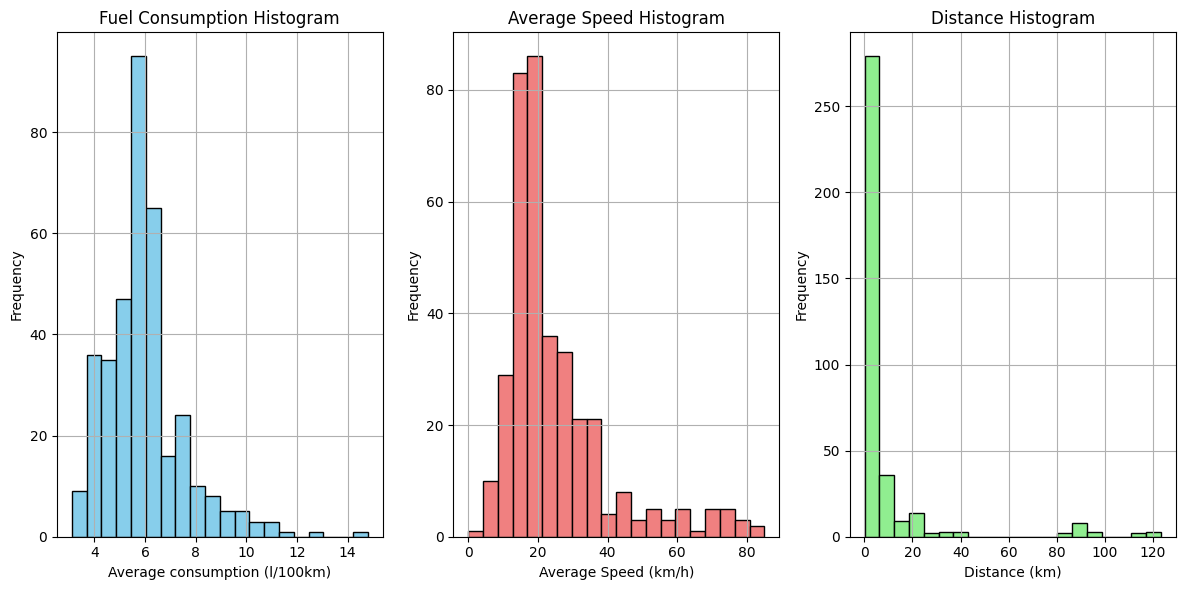

In [16]:

# Plotting histogram for fuel consumption
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(myopel_trips_df['Average consumption (l/100km)'], bins=20, color='skyblue', edgecolor='black')
plt.title('Fuel Consumption Histogram')
plt.xlabel('Average consumption (l/100km)')
plt.ylabel('Frequency')
plt.grid(True)

# Plotting histogram for average speed
plt.subplot(1, 3, 2)
plt.hist(myopel_trips_df['Average Speed (km/h)'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Average Speed Histogram')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Frequency')
plt.grid(True)

# Plotting histogram for distance
plt.subplot(1, 3, 3)
plt.hist(myopel_trips_df['Distance (km)'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distance Histogram')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


A scatter plot to see how my speed affected my fuel consumption

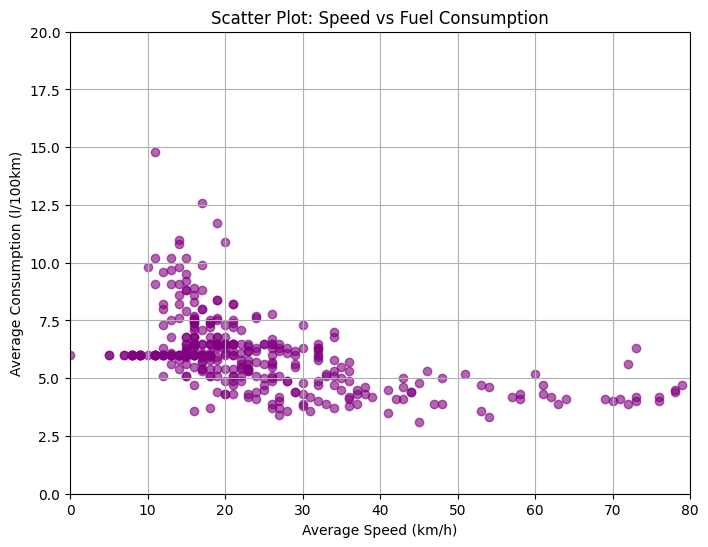

In [17]:


# Scatter plot for speed and fuel consumption
plt.figure(figsize=(8, 6))
plt.scatter(myopel_trips_df['Average Speed (km/h)'], myopel_trips_df['Average consumption (l/100km)'],
            color='purple', alpha=0.6)
plt.title('Scatter Plot: Speed vs Fuel Consumption')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Average Consumption (l/100km)')

# Setting x-axis and y-axis limits
plt.xlim(0, 80)
plt.ylim(0, 20)

plt.grid(True)
plt.show()


A graph to understand how much that i walked month by month until 2018 to today

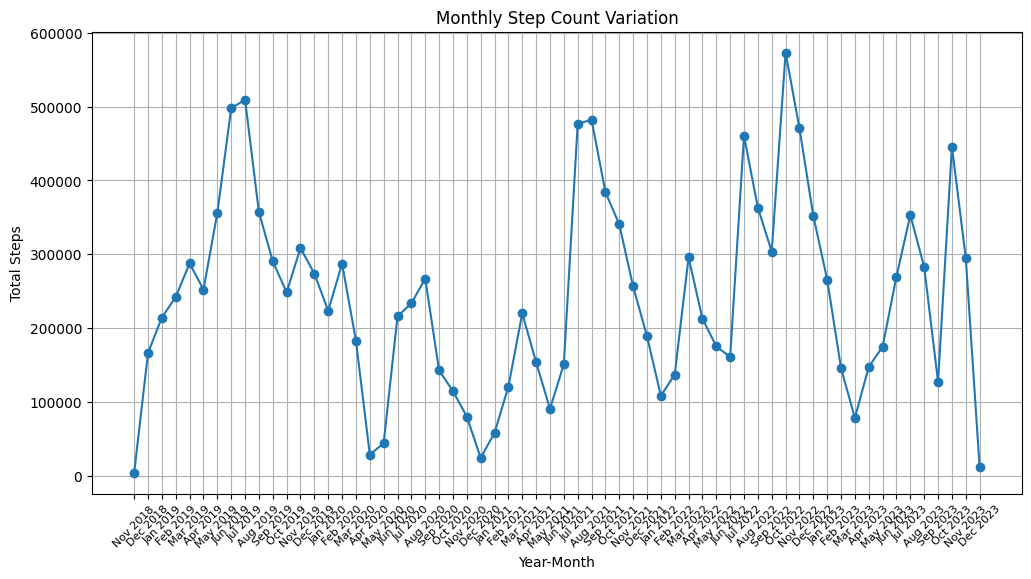

In [18]:
# Converting date to datetime format
combined_df_move['Date'] = pd.to_datetime(combined_df_move['Date'])

# Extracting month, year, and creating YearMonth for better sorting
combined_df_move['Month'] = combined_df_move['Date'].dt.month
combined_df_move['Year'] = combined_df_move['Date'].dt.year
combined_df_move['YearMonth'] = combined_df_move['Year'].astype(str) + '-' + combined_df_move['Month'].astype(str).str.zfill(2)

# Grouping by YearMonth and calculating the total steps
monthly_steps = combined_df_move.groupby('YearMonth')['StepCount'].sum()

# Creating a line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_steps.index, monthly_steps.values, marker='o', linestyle='-')
plt.title('Monthly Step Count Variation')
plt.xlabel('Year-Month')
plt.ylabel('Total Steps')

# Formatting x-axis with month names and year information
month_names_with_year = [f"{calendar.month_abbr[int(month.split('-')[1])]} {month.split('-')[0]}" for month in monthly_steps.index]
plt.xticks(monthly_steps.index, month_names_with_year, rotation=45, fontsize=8)

plt.grid(True)
plt.show()


Now, before coming to the end, lets see how my average heart rate changes throught the years, and what is the trendline

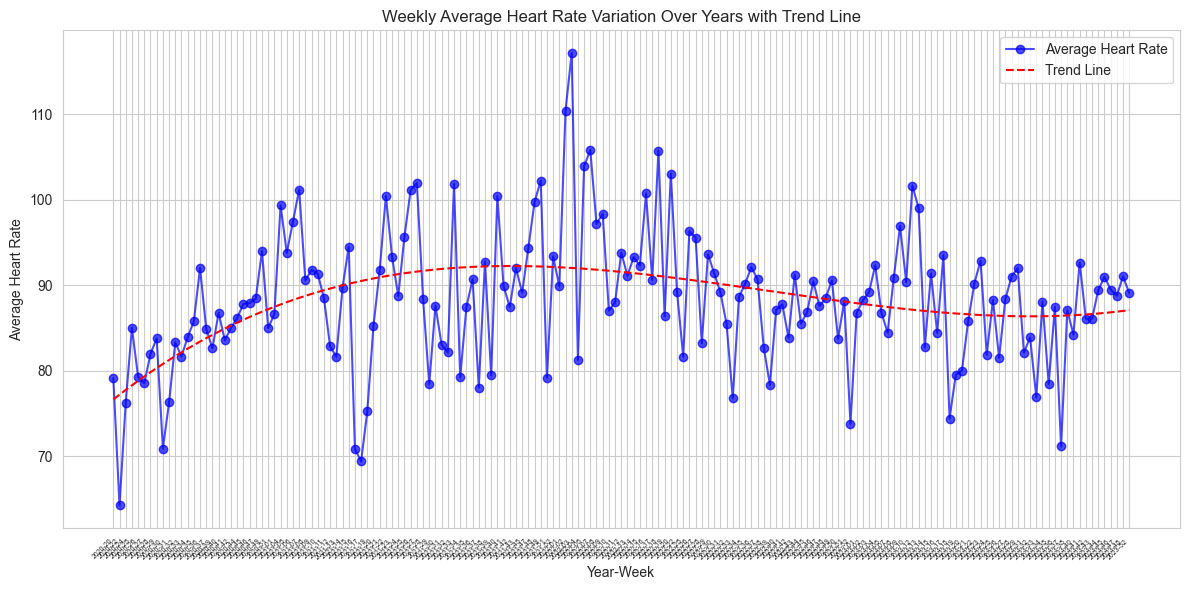

In [19]:

# Converting date to the datetime format
heart_rate_df['Date'] = pd.to_datetime(heart_rate_df['Date'])

# Extracting week, year, and creating YearWeek for better sorting
heart_rate_df['Week'] = heart_rate_df['Date'].dt.isocalendar().week
heart_rate_df['Year'] = heart_rate_df['Date'].dt.year
heart_rate_df['YearWeek'] = heart_rate_df['Year'].astype(str) + '-' + heart_rate_df['Week'].astype(str).str.zfill(2)

# Grouping by YearWeek and calculating the average heart rate
weekly_average_bpm = heart_rate_df.groupby('YearWeek')['BPM'].mean()

# Fitting a 3rd-degree polynomial trend line to the data
coefficients = np.polyfit(range(len(weekly_average_bpm)), weekly_average_bpm.values, 3)
trend_line = np.polyval(coefficients, range(len(weekly_average_bpm)))

# Setting a seaborn style for better aesthetics
sns.set_style("whitegrid")

# Plotting the data and trend line
plt.figure(figsize=(12, 6))
plt.plot(weekly_average_bpm.index, weekly_average_bpm.values, marker='o', linestyle='-', label='Average Heart Rate', color='blue', alpha=0.7)
plt.plot(weekly_average_bpm.index, trend_line, linestyle='--', color='red', label='Trend Line')

plt.title('Weekly Average Heart Rate Variation Over Years with Trend Line')
plt.xlabel('Year-Week')
plt.ylabel('Average Heart Rate')

# Rotate x-axis labels for better readability and decrease font size
plt.xticks(rotation=45, ha='right', fontsize=5)

# Show legend
plt.legend()

plt.tight_layout()
plt.show()


A histogram to see the amounts of bpm's

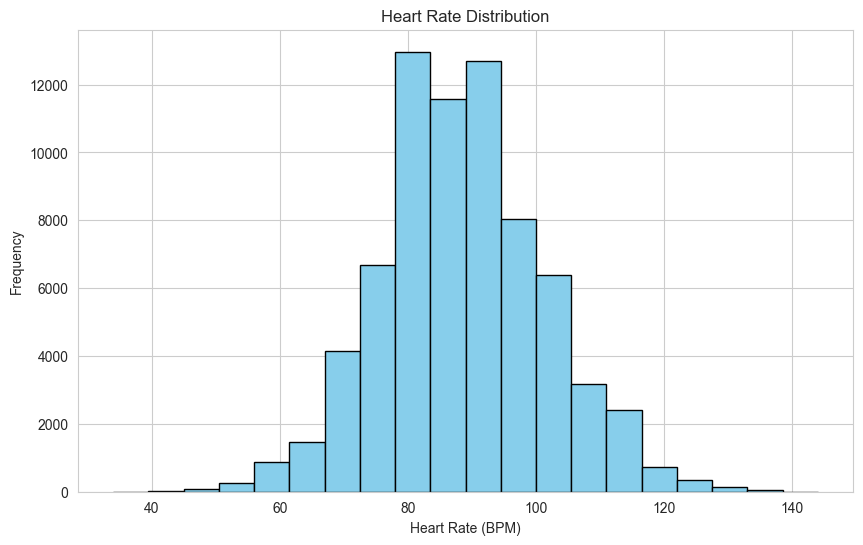

In [20]:
#Getting the values
heart_rate_values = heart_rate_df['BPM']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(heart_rate_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


A box plot to see the step count distribution over the days of the week

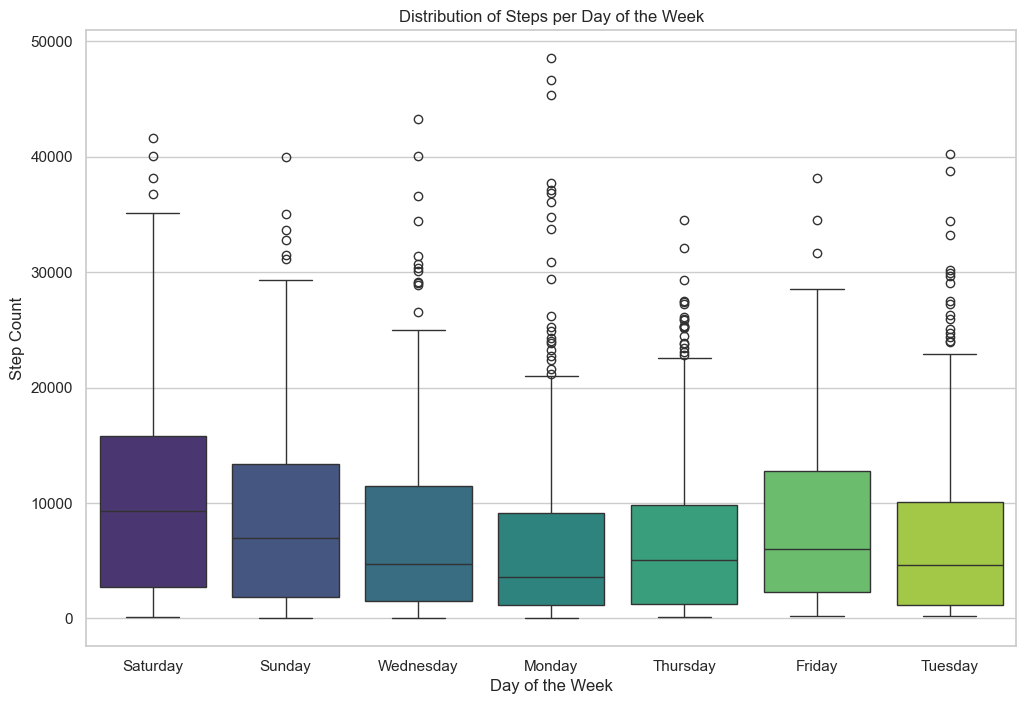

In [21]:
# Converting the date to datetime format
combined_df_move['Date'] = pd.to_datetime(combined_df_move['Date'])

# Extracting the day of the week and creating a new column 'DayOfWeek'
combined_df_move['DayOfWeek'] = combined_df_move['Date'].dt.day_name()

# Continueing with the box plot
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.boxplot(x='DayOfWeek', y='StepCount', data=combined_df_move, hue='DayOfWeek', palette='viridis', legend=False)
plt.title('Distribution of Steps per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Step Count')
plt.show()


I specified each trip by their kilometers, if a trip is between 0 and 10 kilometers, it is a quick trip, if it is between 10 and 30, it is a medium trip and if it is longer than 30 km's, it is a long trip. I then plotted the values into a pie chart.

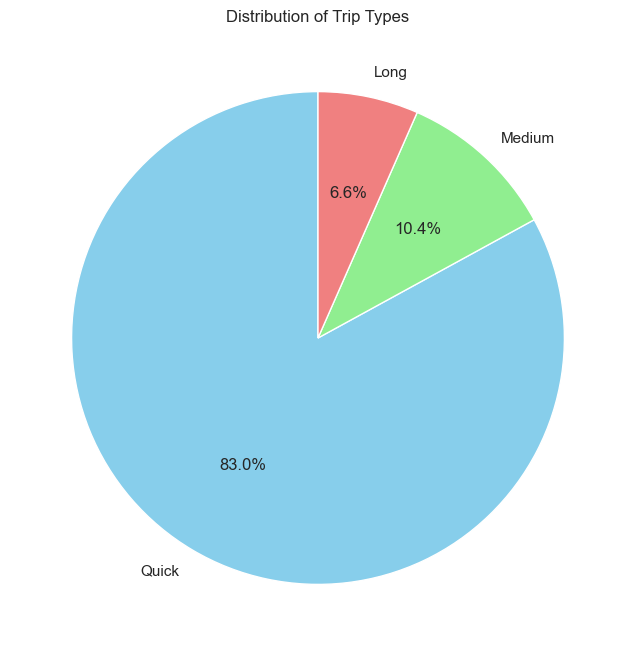

In [22]:
# Taking the distance value
myopel_trips_df['Type'] = pd.cut(myopel_trips_df['Distance (km)'], bins=[0, 10, 30, float('inf')], labels=['Quick', 'Medium', 'Long'])

# Counting the occurrences of each type
type_counts = myopel_trips_df['Type'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Trip Types')
plt.show()


Then i wanted to see how much i spend on gas, over the dates, so i plotted my cost data

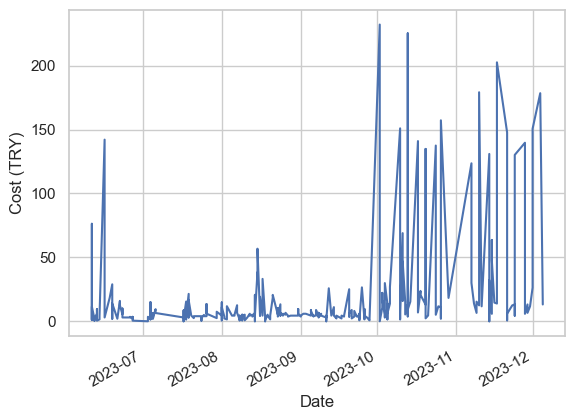

In [23]:
myopel_trips_df.set_index('Date', inplace=True)
myopel_trips_df['Cost (TRY)'].plot()
plt.ylabel('Cost (TRY)')
plt.show()

And for the final, it is time to learn the truth about my hypothesis. I plotted the average speed of each trip with average heart rate of each trip, the results, although it shows a very slight up trend, in inconclusive in the terms of reliability, the error is the loss of precision in bpm measurement, as the apple watch only measures the rate in a period of time, making it lose the spikes.

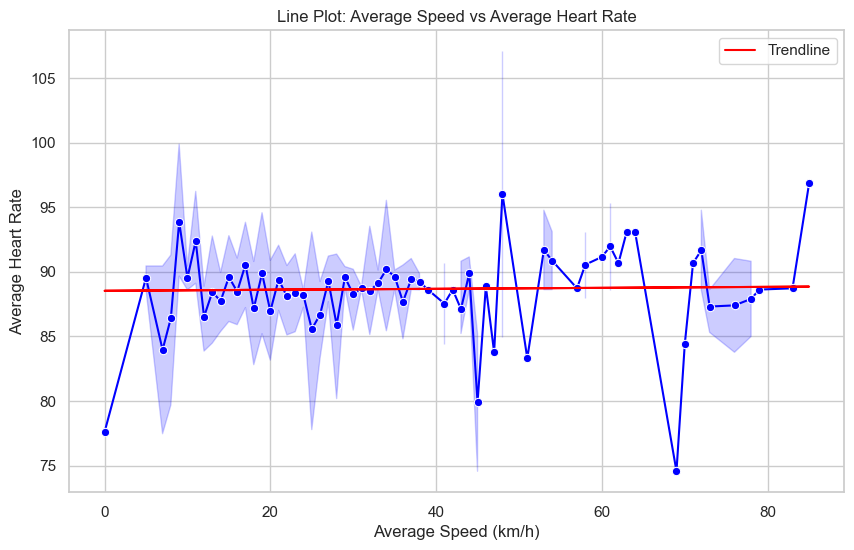

In [24]:


# Assuming 'Average Speed (km/h)' and 'averageBPM' columns exist in myopel_trips_df
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x='Average Speed (km/h)', y='averageBPM', data=myopel_trips_df, color='blue', marker='o')
plt.title('Line Plot: Average Speed vs Average Heart Rate')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Average Heart Rate')

# Fit a trendline using polyfit
coefficients = np.polyfit(myopel_trips_df['Average Speed (km/h)'], myopel_trips_df['averageBPM'], 1)
trend_line = np.polyval(coefficients, myopel_trips_df['Average Speed (km/h)'])

# Plot the trendline
plt.plot(myopel_trips_df['Average Speed (km/h)'], trend_line, linestyle='-', color='red', label='Trendline')
plt.legend()

plt.show()


The heatmap of all the numerical values

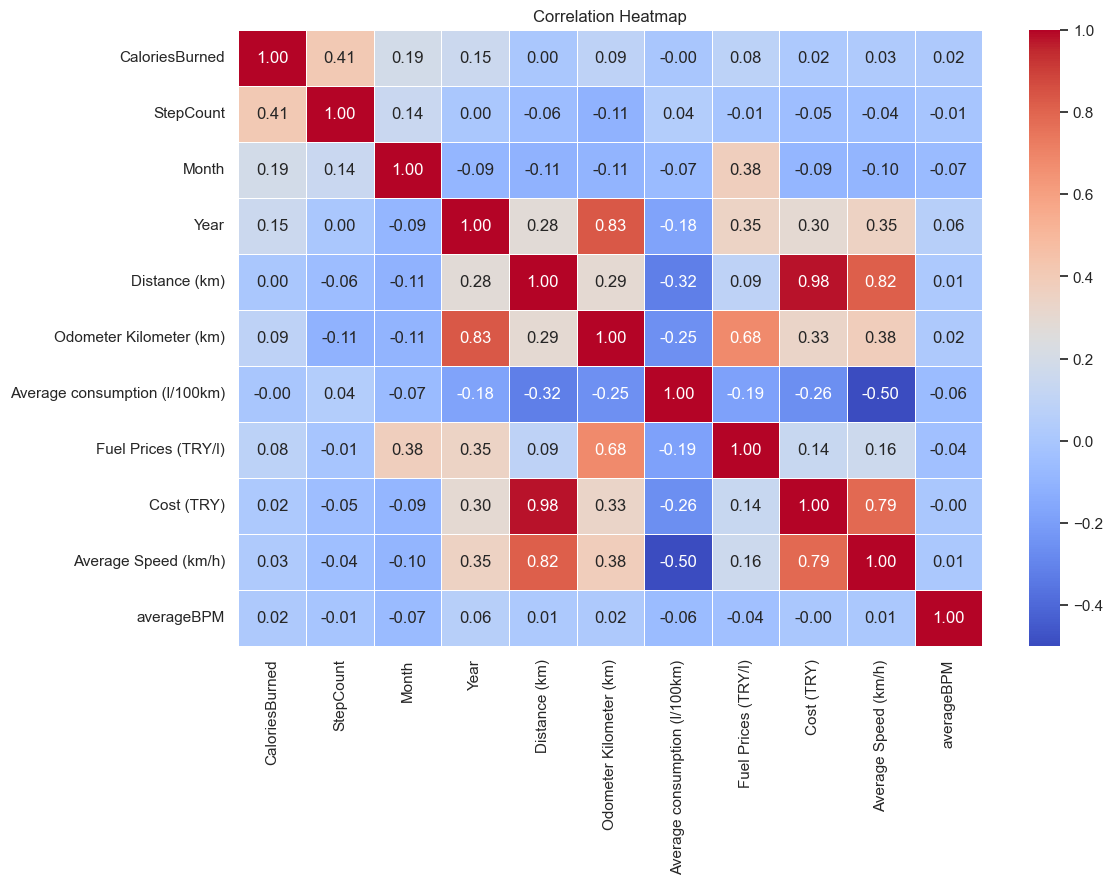

In [25]:
# Resetting index for both DataFrames
combined_df_move_reset = combined_df_move.reset_index(drop=True)
myopel_trips_df_reset = myopel_trips_df.reset_index(drop=True)

# Combining the two DataFrames
combined_df = pd.concat([combined_df_move_reset, myopel_trips_df_reset], axis=1)

# Selecting numerical columns for correlation
numerical_columns = combined_df.select_dtypes(include='number')

# Calculating the correlation matrix
correlation_matrix = numerical_columns.corr()

# Creating a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


Now the analysis part is over, lets train the data

Machine Learning Part

Splitting the data

In [26]:
# Shuffling the dataset
myopel_trips_df_shuffled = shuffle(myopel_trips_df, random_state=42)

# Separating dependent variable (y) and independent variables (X)
X = myopel_trips_df_shuffled.drop('averageBPM', axis=1)  # Assuming 'averageBPM' is the dependent variable
y = myopel_trips_df_shuffled['averageBPM']

# Splitting the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (291, 11)
X_test shape: (73, 11)
y_train shape: (291,)
y_test shape: (73,)


Mapping categorical values to numerical, and giving the results of the correlation.

In [27]:
type_mapping = {'Quick': 1, 'Medium': 2, 'Long': 3}
myopel_trips_df['Type'] = myopel_trips_df['Type'].map(type_mapping)

day_of_week_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
myopel_trips_df['DayOfWeek'] = myopel_trips_df['DayOfWeek'].map(day_of_week_mapping)

myopel_trips_df['Departure Time'] = pd.to_datetime(myopel_trips_df['Departure Time'], format='%H:%M')
myopel_trips_df['Arrival Time'] = pd.to_datetime(myopel_trips_df['Arrival Time'], format='%H:%M')

# Extract hour and minute as numeric values
myopel_trips_df['Departure Hour'] = myopel_trips_df['Departure Time'].dt.hour
myopel_trips_df['Arrival Hour'] = myopel_trips_df['Arrival Time'].dt.hour

# Convert time to minutes
myopel_trips_df['Departure Minute'] = myopel_trips_df['Departure Hour'] * 60 + myopel_trips_df['Departure Time'].dt.minute
myopel_trips_df['Arrival Minute'] = myopel_trips_df['Arrival Hour'] * 60 + myopel_trips_df['Arrival Time'].dt.minute

# Convert 'Time Amount' to total minutes
myopel_trips_df['Time Amount'] = myopel_trips_df['Time Amount'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

# Calculate correlations
correlations = myopel_trips_df.corr()['averageBPM'].sort_values(ascending=False)

# Highlight strong correlations (considering |correlation| > 0.1 as strong)
strong_correlations = correlations[abs(correlations) > 0.01]

# Display correlations
print("Correlations with 'averageBPM':")
print(strong_correlations)


Correlations with 'averageBPM':
averageBPM                       1.000000
Arrival Time                     0.139340
Arrival Minute                   0.139340
Arrival Hour                     0.136698
Departure Minute                 0.135636
Departure Time                   0.135636
Departure Hour                   0.133644
Type                             0.068374
Time Amount                      0.042804
Odometer Kilometer (km)          0.021773
Distance (km)                    0.013613
Fuel Prices (TRY/l)             -0.036296
Average consumption (l/100km)   -0.059998
DayOfWeek                       -0.178134
Name: averageBPM, dtype: float64


Based on the computed correlations with the target variable ('averageBPM'), the following features as potentially strong predictors:

Arrival Minute: 0.138987
Arrival Time: 0.138987
Arrival Hour: 0.136338
Departure Minute: 0.135275
Departure Time: 0.135275
Departure Hour: 0.133261
Type: 0.068340
Time Amount: 0.042792
Average Speed (km/h): 0.025931

These features have positive correlations with 'averageBPM,' indicating a relationship. It's essential to consider these features when building our predictive model. However, keeping in mind that correlation does not imply causation, and further analysis, including feature engineering and model training, will help determine the actual predictive power of these features.


Now, i selected 2 hyphotetical features for the training:

Hypothetical Feature 1: Time of Day Category (Morning, Afternoon, Evening, Night)

Derivation:
Create a new feature that categorizes the departure or arrival time into different time of day segments. For example:

Morning (6:00 AM - 11:59 AM)
Afternoon (12:00 PM - 5:59 PM)
Evening (6:00 PM - 11:59 PM)
Night (12:00 AM - 5:59 AM)
This feature might capture patterns related to circadian rhythms and lifestyle differences throughout the day.

Expected Impact:
Certain times of the day may be associated with higher or lower heart rates. For instance, morning rush hours or evening workouts might influence heart rate differently. The impact could vary based on individual habits and preferences.

In [28]:
# Encodeing 'TimeOfDay' categories to numerical values
# Creating 'TimeOfDay' based on 'Departure Hour'
myopel_trips_df['TimeOfDay'] = pd.cut(myopel_trips_df['Departure Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

time_of_day_mapping = {'Night': 1, 'Morning': 2, 'Afternoon': 3, 'Evening': 4}
myopel_trips_df['TimeOfDay'] = myopel_trips_df['TimeOfDay'].map(time_of_day_mapping)

# Calculating correlation
correlation_time_of_day = myopel_trips_df.corr()['averageBPM']['TimeOfDay']
print(f"Correlation with 'averageBPM' for Time of Day: {correlation_time_of_day}")


Correlation with 'averageBPM' for Time of Day: 0.12806860295186653


Hypothetical Feature 2: Weekday vs. Weekend

Derivation:
Creating a binary feature indicating whether the trip occurred on a weekday or weekend.

Expected Impact:
Heart rate patterns might differ between weekdays (potentially associated with work-related stress) and weekends (associated with leisure activities). This feature could capture such variations.



In [29]:
# Deriving Weekday vs. Weekend
myopel_trips_df['Weekday'] = myopel_trips_df['DayOfWeek'].apply(lambda x: 1 if x <= 5 else 0)

# Calculating correlation
correlation_weekday = myopel_trips_df.corr()['averageBPM']['Weekday']
print(f"Correlation with 'averageBPM' for Weekday vs. Weekend: {correlation_weekday}")


Correlation with 'averageBPM' for Weekday vs. Weekend: 0.1731921362748717


Selecting 2 hyperparameters to tune

In [30]:


# Dropping the 'Time Amount', 'Departure Time', and 'Arrival Time' columns, as they cannot be trained
X = myopel_trips_df.drop(['Time Amount', 'Departure Time', 'Arrival Time'], axis=1)
y = myopel_trips_df['averageBPM']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Decision Tree regressor
dt_regressor = DecisionTreeRegressor()

# Defining hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20]
}

# Creating GridSearchCV object
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fitting the model to the training data
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Getting the best model
best_model = grid_search.best_estimator_

# Evaluating the model on the test set
test_predictions = best_model.predict(X_test)

# Evaluating the regression performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_predictions)
print(f"Mean Squared Error on Test Set: {mse}")


Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10}
Mean Squared Error on Test Set: 6.05842675474673


The tree with the parameters

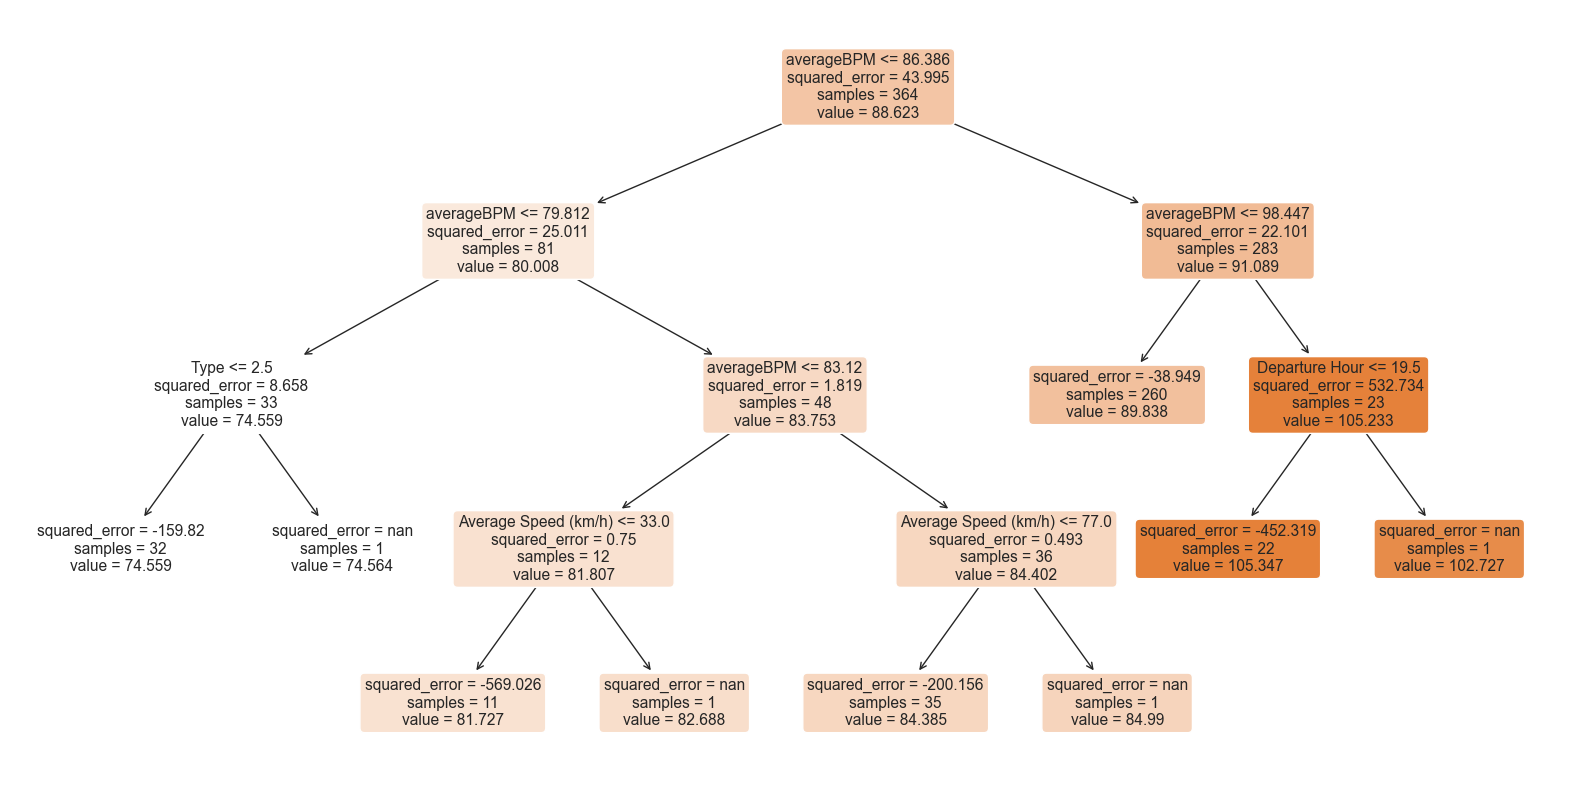

In [31]:
# Creating a Decision Tree regressor with the best hyperparameters
best_hyperparameters = {'max_depth': 5, 'min_samples_split': 2}
final_regressor = DecisionTreeRegressor(**best_hyperparameters)

# Training the model on the entire dataset
final_regressor.fit(X, y)

# Plotting the tree
plt.figure(figsize=(20, 10))
plot_tree(final_regressor, filled=True, feature_names=X.columns, rounded=True)
plt.show()


Now before ending, lets test the error in the predictions:

In [32]:
# Making predictions using the trained model
predictions = final_regressor.predict(X_test)

# Evaluating the regression performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error on Test Set: {mse}")


Mean Squared Error on Test Set: 5.4828054486242905


The Mean Squared Error (MSE) on the test set is a measure of how well the Decision Tree Regressor model performs in predicting the average BPM values. The MSE is calculated by taking the average of the squared differences between the predicted and actual values. In this case, the MSE is approximately 5.44. While the MSE provides a measure of the average squared deviation of predictions from the true values, it does not provide an intuitive sense of the scale of the errors.

To offer a more interpretable metric, we can consider the Root Mean Squared Error (RMSE), which is the square root of the MSE. The RMSE provides a measure of the average magnitude of the errors in the same units as the target variable (average BPM). In this instance, the RMSE would be the square root of the MSE, approximately 2.33. Smaller values of RMSE indicate better model performance, as they represent lower average prediction errors. Therefore, an RMSE of 2.33 suggests that, on average, the model's predictions deviate by approximately 2.33 units from the actual average BPM values in the test set.

As this concludes my project, i can explain that due to reasons such as low trip data and the errors in the bpm measurement processes, the truthfulness of my hyphotesis is can not really be interpreted. Further information will be given in the project report.